# Individual water values in SHOP

The model setup for the three examples are available in the following formats:

- pyshop
    - [ind_wv.py](#ind_wv.py)
- YAML
    - [model.yaml](#model.yaml)
    - [constant_energy_value.yaml](#constant_energy_value.yaml)
    - [constant_mixed_values.yaml](#constant_mixed_values.yaml)
    - [water_value_tables.yaml](#water_value_tables.yaml)
- ASCII
    - [model.ascii](#model.ascii)
    - [constant_energy_values.ascii](#constant_energy_values.ascii)
    - [constant_mixed_values.ascii](#constant_mixed_values.ascii)
    - [water_value_tables.ascii](#water_value_tables.ascii)
      

The examples show how to use constant water values (in €/Mm$^3$ and €/MWh) and water value tables to specify the end value of the end reservoir contents in SHOP. A simple case with three reservoirs and two plants is used to illustrate some of the relevant input and output for individual water values.

In [1]:
#Necessary imports used in all examples
import pandas as pd
import cufflinks as cf
import plotly.offline as py
import plotly.graph_objs as go
cf.go_offline()
py.offline.init_notebook_mode(connected=True)
from pyshop import ShopSession

#Functions used in this example for building a tunnel model, adding a gate to a tunnel and running the optimization
from ind_wv import build_model, run_model

## Constant water values in €/MWh
The first example will use **energy_value_input** to specify an end value in €/MWh for all three reservoirs (see figure below).

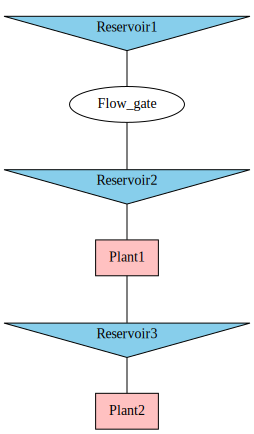

In [2]:
#Create a standard ShopSession
shop=ShopSession()
#Build a simple model with three reservoirs and two plants.
build_model(shop)
#Display topology to the screen
display(shop.model.build_connection_tree())

#The three reservoir objects
rsv1 = shop.model.reservoir.Reservoir1
rsv2 = shop.model.reservoir.Reservoir2
rsv3 = shop.model.reservoir.Reservoir3

#In the first run we define the end value of the water in terms of €/MWh with the energy_value_input attribute
rsv1.energy_value_input.set(31.0)
rsv2.energy_value_input.set(30.0)
rsv3.energy_value_input.set(20.0)

#Optimize model by calling "run_model"
run_model(shop)

Let us take a look at the conversion factors and global water values calculated by SHOP:

In [3]:
#Print out the energy conversion factors for all reservoirs used in the conversion from €/MWh -> €/Mm3
for rsv in shop.model.reservoir:
    print(f"{rsv.get_name()} has an energy conversion factor of {rsv.energy_conversion_factor.get():.3f} MWh/Mm3")
print("")

#Print out the calculated global water value for all reservoirs.
for rsv in shop.model.reservoir:
    print(f"{rsv.get_name()} has a calculated global water value of {rsv.calc_global_water_value.get():.2f} €/Mm3")
print("")

#Optimization results for the total reservoir end values
for rsv in shop.model.reservoir:
    end_val = -rsv.end_value.get()[-1]
    end_vol = rsv.storage.get()[-1]
    avrg_wv = end_val/(end_vol+10**(-10))

    print(f"{rsv.get_name()} has a total value of {end_val:.2f} € at {end_vol:.2f} Mm3 and an average water value of {avrg_wv:.2f} €/Mm3")
print("")

Reservoir1 has an energy conversion factor of 583.001 MWh/Mm3
Reservoir2 has an energy conversion factor of 583.001 MWh/Mm3
Reservoir3 has an energy conversion factor of 205.225 MWh/Mm3

Reservoir1 has a calculated global water value of 22177.52 €/Mm3
Reservoir2 has a calculated global water value of 21594.52 €/Mm3
Reservoir3 has a calculated global water value of 4104.50 €/Mm3

Reservoir1 has a total value of 186291.15 € at 8.40 Mm3 and an average water value of 22177.52 €/Mm3
Reservoir2 has a total value of 533731.72 € at 24.72 Mm3 and an average water value of 21594.52 €/Mm3
Reservoir3 has a total value of 21340.00 € at 5.20 Mm3 and an average water value of 4104.50 €/Mm3



The **energy_conversion_factor** for Reservoir1 and Reservoir2 are identical since they are referred to the same plant. The **calc_global_water_value** attribute is the calculated global water value in €/Mm$^3$ based on the energy_input_value and energy_conversion_factor. This is simply the product of the two values for Reservoir3 since there is no reservoir below it. The respective local water values (energy_value_input$\cdot$energy_conversion_factor) for Reservoir1 and Reservoir2 are added to the downstream global water value from Reservoir3 to find their global water values.

The average water value, calculated by dividing the optimized end value by the end volume of each reservoir, gives the same result as the calculated global water value - as it should in a constant water value case!

The storage volume, global water value (**water_value_global_result**), and local energy value (**energy_value_local_result**) from the optimization results are shown in the plots below. The water_value_global_result is the dual value of the reservoir balance constraints, and are directly extracted from the optimization problem. These values are usually negative due to the way the constraints are modelled in SHOP. The energy_value_local_result attribute is found by first calculating the local water value of the reservoir relative to the reservoir below the plant, and then converting it to €/MWh with the energy_conversion_factor.

A good consistency check is to look at the (negative of the) final values of the water_value_global_result and energy_value_local_results time series. These should be identical to the global water value and energy_value_input, respectively. This identity may not hold if penalties are present in the SHOP run since the dual values of the problem are influenced by penalty values.

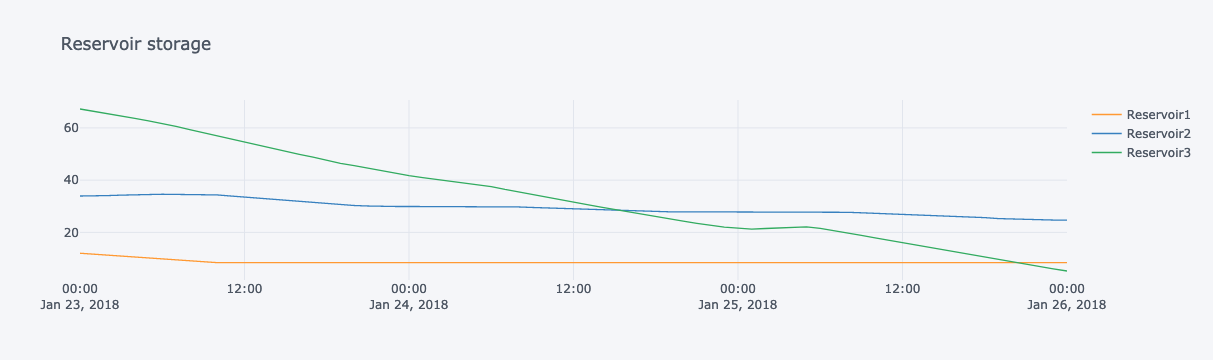

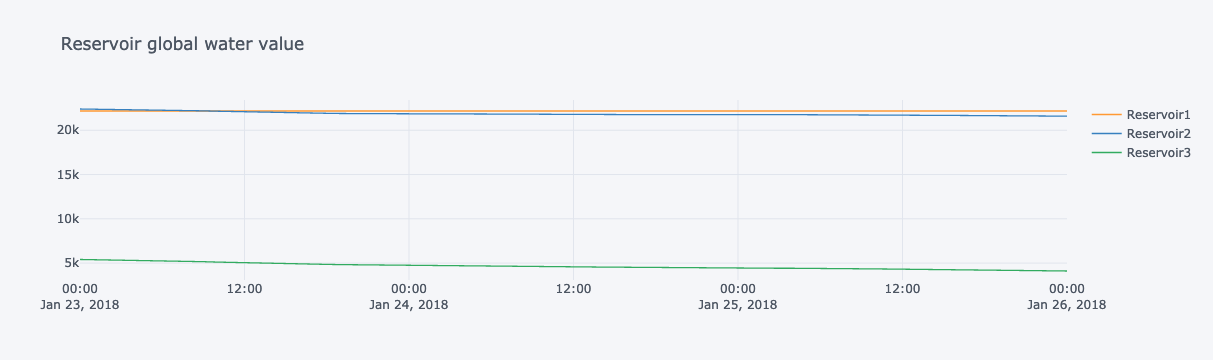

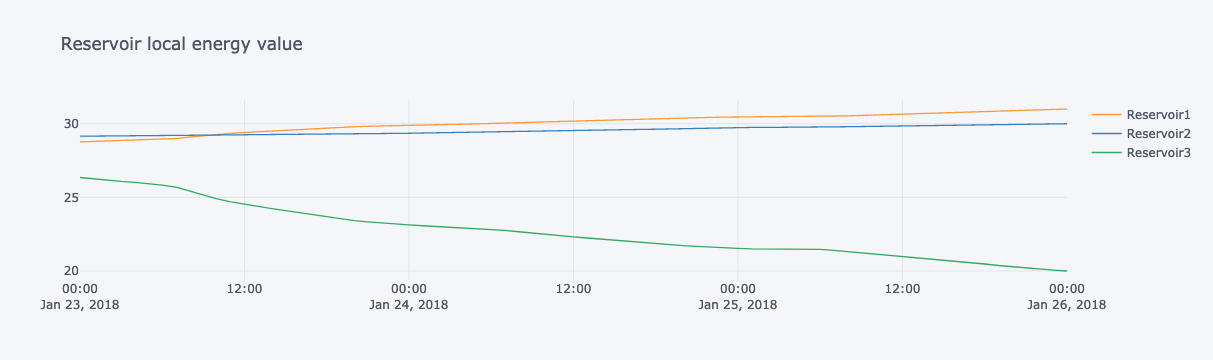

In [4]:
pd.DataFrame([rsv.storage.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir storage")
pd.DataFrame([-rsv.water_value_global_result.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir global water value")
pd.DataFrame([-rsv.energy_value_local_result.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir local energy value")

## Mix of constant water values in €/MWh and €/Mm$^3$
It is possible to define constant water values in €/MWh for some reservoirs and €/Mm$^3$ for the rest. Constant water values in €/Mm$^3$ are used directly by SHOP since they are assumed to be global and don't have to be converted. The example below is identical to the previous one except that the enrgy_value_input of Reservoir3 has been changed to a constant global water value with the **water_value_input** attribute. 

Caution is advised when having both definitions in the system, as it is possible to create cases where the global water value is not increasing upwards in the system. In our example, setting a high water_value_input for Reservoir2 could make it higher than the calculated global water value of Reservoir1. This can happen because the energy_value_input is a local value relative to the reservoir below the downstream plant, and so the global water value of Reservoir2 is skipped when converting the energy_value_input into a global water value for Reservoir1.

In [5]:
#Create the same basic model as before
shop=ShopSession()
build_model(shop)

#The three reservoir objects
rsv1 = shop.model.reservoir.Reservoir1
rsv2 = shop.model.reservoir.Reservoir2
rsv3 = shop.model.reservoir.Reservoir3

#We keep the energy_value_input for rsv1 and rsv2 unchanged, but define a global water value of 4000 €/Mm3 for rsv3 which is slightly higher than in the previous example.
rsv1.energy_value_input.set(31.0)
rsv2.energy_value_input.set(30.0)
rsv3.water_value_input.set([pd.Series([5000.0], index=[0], name=0)])

#Optimize model by calling "run_model"
run_model(shop)

#The energy_conversion_factors
for rsv in shop.model.reservoir:
    print(f"{rsv.get_name()} has an energy conversion factor of {rsv.energy_conversion_factor.get():.3f} MWh/Mm3")
print("")

#The calculated global water values
for rsv in shop.model.reservoir:
    print(f"{rsv.get_name()} has a calculated global water value of {rsv.calc_global_water_value.get():.2f} €/Mm3")
print("")

#Optimization results
for rsv in shop.model.reservoir:
    end_val = -rsv.end_value.get()[-1]
    end_vol = rsv.storage.get()[-1]
    avrg_wv = end_val/(end_vol+10**(-10))
    print(f"{rsv.get_name()} has a total value of {end_val:.2f} € at {end_vol:.2f} Mm3 and an average water value of {avrg_wv:.2f} €/Mm3")
print("")

Reservoir1 has an energy conversion factor of 583.001 MWh/Mm3
Reservoir2 has an energy conversion factor of 583.001 MWh/Mm3
Reservoir3 has an energy conversion factor of 205.225 MWh/Mm3

Reservoir1 has a calculated global water value of 23073.02 €/Mm3
Reservoir2 has a calculated global water value of 22490.02 €/Mm3
Reservoir3 has a calculated global water value of 0.00 €/Mm3

Reservoir1 has a total value of 210425.94 € at 9.12 Mm3 and an average water value of 23073.02 €/Mm3
Reservoir2 has a total value of 588873.82 € at 26.18 Mm3 and an average water value of 22490.02 €/Mm3
Reservoir3 has a total value of 79143.61 € at 15.83 Mm3 and an average water value of 5000.00 €/Mm3



Note that all of the energy conversion factors are identical to the first example since they are not influenced by the water value function of the reservoirs. The calc_global_water_value attribute is not calculated for Reservoir3 since it already has a global water value given in €/Mm$^3$. The calculated global water values of Reservoir1 and Reservoir2 are higher compared to the last example since the water value for Reservoir3 is higher, but their relative difference is the same as before.

The final value of the local energy value time series for Reservoir1 and Reservoir2 are still the same as their energy_value_input, while the water_value_input defined for Reservoir3 is found in the final value of the global water value time series. 

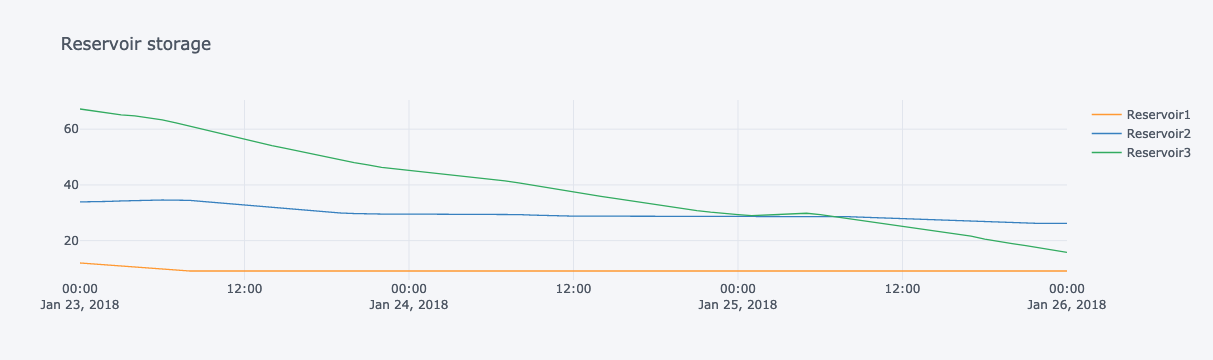

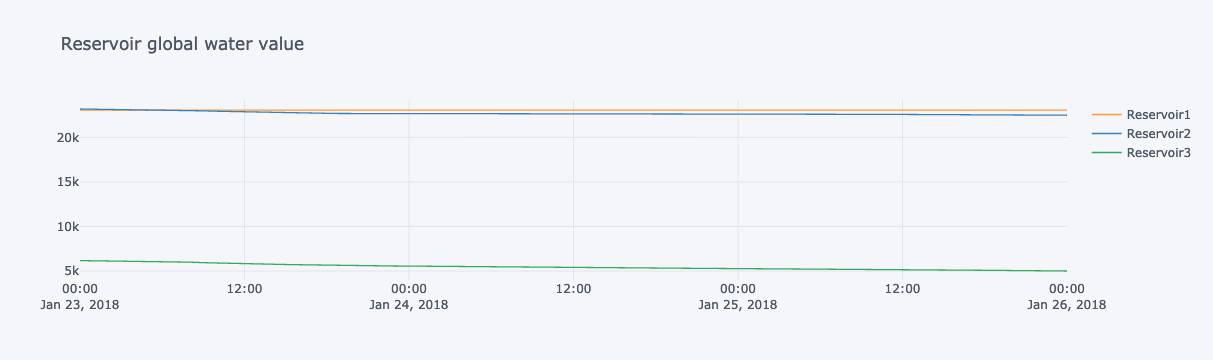

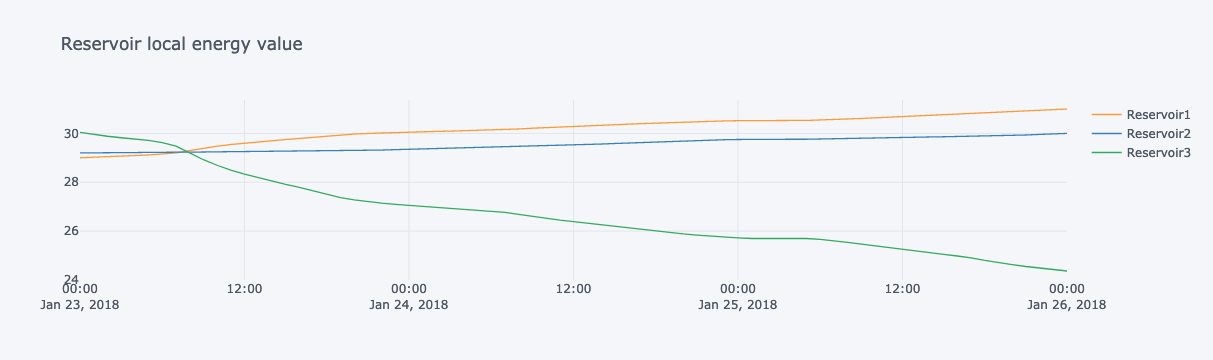

In [6]:
pd.DataFrame([rsv.storage.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir storage")
pd.DataFrame([-rsv.water_value_global_result.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir global water value")
pd.DataFrame([-rsv.energy_value_local_result.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir local energy value")


## Water value tables
An example of how to specify water values as piece-wise constant functions are shown below. The tables are based on the original water values calculated in the first example. The marginal water values in the water value table are spread around the original water value in a uniform way for each volume segment.

It is possible to have reservoirs with constant water values in €/Mm$^3$ and reservoirs with water value tables in the same system, but it is not advisable to mix water value tables and constant end values in €/MWh. This is because the conversion from local energy values to global water values requires a constant water value for all reservoirs of the system. If reservoirs with water value tables and constant local energy values are mixed, the start volume is used to find an approximation of the global water value of the reservoirs with water value tables.

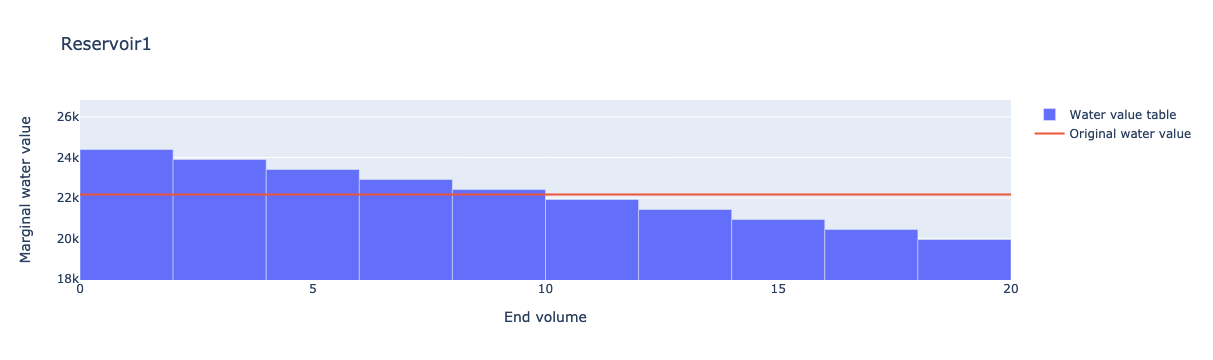

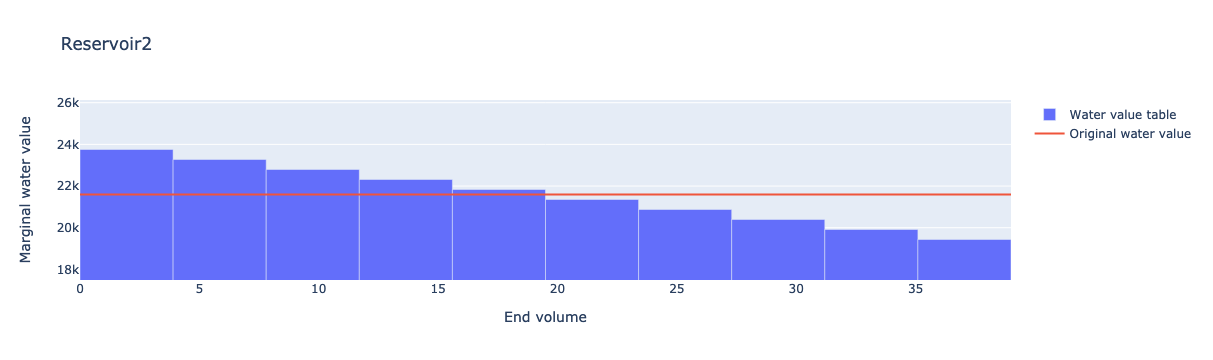

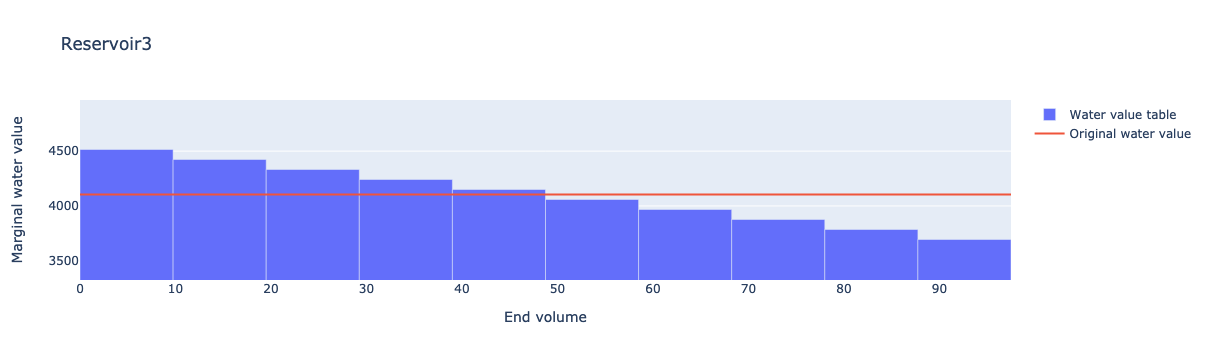


Reservoir1:
Vol WV
0.0 24395.272
2.0 23902.438222222223
4.0 23409.604444444445
6.0 22916.770666666667
8.0 22423.93688888889
10.0 21931.10311111111
12.0 21438.269333333334
14.0 20945.435555555556
16.0 20452.601777777778
18.0 19959.768

Reservoir2:
Vol WV
0.0 23753.972
3.9 23274.09377777778
7.8 22794.215555555555
11.7 22314.337333333333
15.6 21834.45911111111
19.5 21354.58088888889
23.4 20874.702666666668
27.3 20394.824444444446
31.2 19914.94622222222
35.1 19435.068

Reservoir3:
Vol WV
0.0 4514.95
9.75 4423.738888888889
19.5 4332.527777777777
29.25 4241.316666666667
39.0 4150.105555555556
48.75 4058.8944444444446
58.5 3967.6833333333334
68.25 3876.472222222222
78.0 3785.261111111111
87.75 3694.05



In [7]:

#Create the same basic model as before
shop=ShopSession()
build_model(shop)

#The three reservoir objects
rsv1 = shop.model.reservoir.Reservoir1
rsv2 = shop.model.reservoir.Reservoir2
rsv3 = shop.model.reservoir.Reservoir3

reservoirs = [rsv1,rsv2,rsv3]

#Create a water value table with n segments that has the same total value at vmax as in the first example
wv_orig = [22177.52,21594.52,4104.50] 
n = 10

for wv,rsv in zip(wv_orig,reservoirs):
    vmax = rsv.max_vol.get()
    delta = 0.1*wv
    #The volume segments are vmax/n long, the marginal water value is decreasing from wv+delta to wv-delta from the first to the last segment
    wv_list = [wv+delta*(1-2*i/(n-1)) for i in range(n)]
    vol_list = [i*vmax/n for i in range(n)]
    rsv.water_value_input.set([pd.Series(wv_list, index=vol_list, name=0)])
    
#Plot the water value tables
for i, rsv in enumerate(reservoirs):
    wv_table = rsv.water_value_input.get()[0]
    vols = list(wv_table.index)
    wvs = list(wv_table.values)
        
    dv = vols[1]-vols[0]
    fig = go.Figure(layout={'bargap':0,'title':f"Reservoir{i+1}",'xaxis_title':"End volume",'yaxis_title':"Marginal water value"})
    fig.add_trace(go.Bar(name='Water value table', x0=0.5*dv,dx=dv, y=wvs))
    fig.add_trace(go.Scatter(name="Original water value",x=[0,vols[-1]+dv],y=[wv_orig[i],wv_orig[i]],mode='lines'))    
    fig.update_yaxes(range=[min(wvs)*0.9, max(wvs)*1.1])
    fig.show()
    print("")
    
#Print the water value tables
for rsv in reservoirs:
    wv_table = rsv.water_value_input.get()[0]
    print(f"{rsv.get_name()}:")
    print("Vol WV")
    for vol,wv in wv_table.items():
        print(vol,wv)    
    print("")

In [8]:
#Optimize model by calling "run_model"
run_model(shop)

for rsv in shop.model.reservoir:
    end_val = -rsv.end_value.get()[-1]
    end_vol = rsv.storage.get()[-1]
    avrg_wv = end_val/(end_vol+10**(-10))

    print(f"{rsv.get_name()} has a total value of {end_val:.2f} € at {end_vol:.2f} Mm3 and an average water value of {avrg_wv:.2f} €/Mm3")
print("")

Reservoir1 has a total value of 246613.78 € at 10.57 Mm3 and an average water value of 23329.77 €/Mm3
Reservoir2 has a total value of 527770.07 € at 23.40 Mm3 and an average water value of 22554.28 €/Mm3
Reservoir3 has a total value of 51482.33 € at 11.44 Mm3 and an average water value of 4501.50 €/Mm3



The results from this SHOP run is not directly comparable to the others even though the water value tables are based on the global water values calulated from the first example. The average water values calculated above are no longer the same as the marginal water values seen in the local water value plot below because of the piece-wise water value definition. The final value of the water_value_global_result are related to the marginal values specified in the water value tables, and it is often equal to the marginal water value in the segment where the final optimized volume lies. However, if the final volume exactly fills a whole number of segments in the table, the marginal value will likely be somewhere between the marginal water value in the last full and first empty segments.

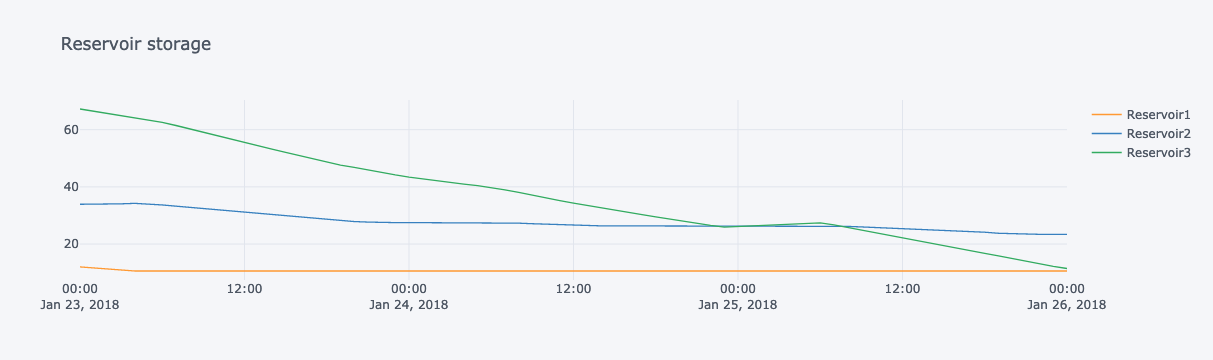

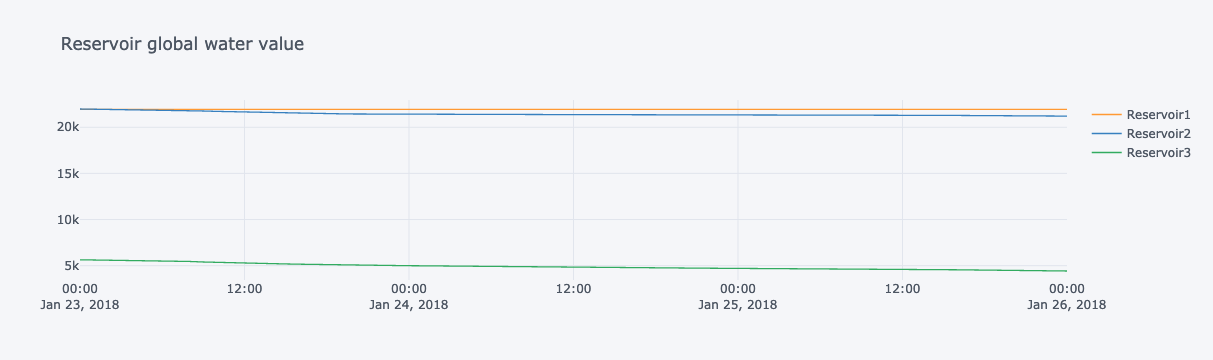

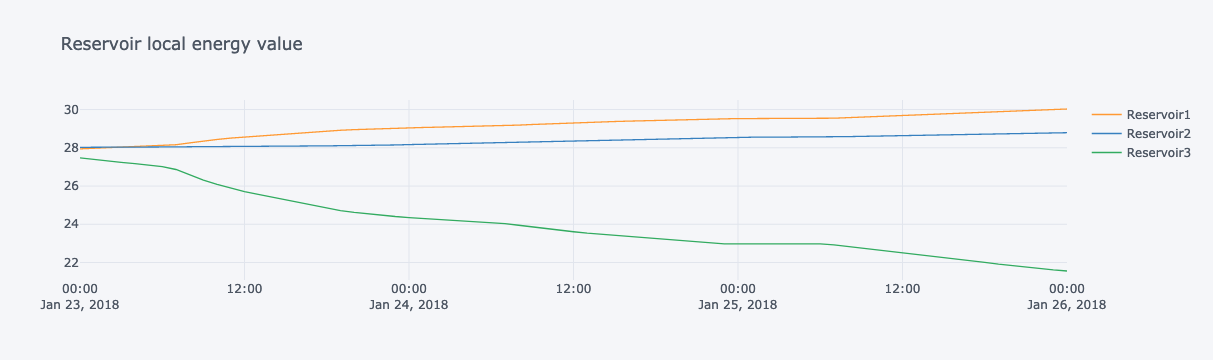

In [19]:
pd.DataFrame([rsv.storage.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir storage")
pd.DataFrame([-rsv.water_value_global_result.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir global water value")
pd.DataFrame([-rsv.energy_value_local_result.get().rename(rsv.get_name()) for rsv in shop.model.reservoir]).transpose().iplot(title="Reservoir local energy value")

## ind_wv.py <a name="ind_wv.py"></a>

In [10]:
%pycat ind_wv.py

import pandas as pd
   
def build_model(shop):

    starttime = pd.Timestamp('2018-01-23 00:00:00')
    endtime = pd.Timestamp('2018-01-26')
    shop.set_time_resolution(starttime=starttime, endtime=endtime, timeunit="hour", timeresolution=pd.Series(index=[starttime],data=[1]))
    
    rsv1 = shop.model.reservoir.add_object('Reservoir1')
    rsv1.max_vol.set(20)
    rsv1.lrl.set(1000)
    rsv1.hrl.set(1010)
    rsv1.vol_head.set(pd.Series([1000, 1010, 1011], index=[0, 20, 22], name=0))
    rsv1.flow_descr.set(pd.Series([0, 1000], index=[1010, 1011], name=0))

    gate = shop.model.gate.add_object('Flow_gate') 
    gate.max_discharge.set(100)    
    
    rsv2 = shop.model.reservoir.add_object('Reservoir2')
    rsv2.max_vol.set(39)
    rsv2.lrl.set(860)
    rsv2.hrl.set(905)
    rsv2.vol_head.set(pd.Series([860, 906, 907], index=[0, 39, 41.66], name=0))    

    rsv3 = shop.model.reservoir.add_object('Reservoir3')
    rsv3.max_vol.set(97.5)   
    rsv3.lrl.set(650)   
    rsv3.hrl.set(

## model.yaml <a name="model.yaml"></a>

In [11]:
%pycat model.yaml

time:
  starttime: 2018-01-23 00:00:00
  endtime: 2018-01-26 00:00:00
  timeunit: hour
  timeresolution:
    2018-01-23 00:00:00: 1
model:
  reservoir:
    Reservoir1:
      start_head: 1006
      max_vol: 20
      lrl: 1000
      hrl: 1010
      vol_head:
        ref: 0
        x:
          - 0
          - 20
          - 22
        y:
          - 1000
          - 1010
          - 1011
      flow_descr:
        ref: 0
        x:
          - 1010
          - 1011
        y:
          - 0
          - 1000
    Reservoir2:
      start_head: 900
      max_vol: 39
      lrl: 860
      hrl: 905
      vol_head:
        ref: 0
        x:
          - 0
          - 39
          - 41.66
        y:
          - 860
          - 906
          - 907
    Reservoir3:
      start_head: 670
      max_vol: 97.5
      lrl: 650
      hrl: 679
      vol_head:
        ref: 0
        x:
          - 0
          - 97.5
          - 104.15
        y:
          - 650
          - 679
          - 680
      inflow:
    

## constant_energy_values.yaml <a name="constant_energy_values.yaml"></a>

In [12]:
%pycat constant_energy_values.yaml

Error: no such file, variable, URL, history range or macro


## constant_mixed_values.yaml <a name="constant_mixed_values.yaml"></a>

In [13]:
%pycat constant_mixed_values.yaml

Error: no such file, variable, URL, history range or macro


## water_value_tables.yaml <a name="water_value_tables.yaml"></a>

In [14]:
%pycat water_value_tables.yaml

model:
  reservoir:
    Reservoir1:      
      water_value_input:
        - ref: 0
          x:
            - 0
            - 2
            - 4
            - 6
            - 8
            - 10
            - 12
            - 14
            - 16
            - 18
          y:
            - 24395.272
            - 23902.438222222
            - 23409.604444444
            - 22916.770666667
            - 22423.936888889
            - 21931.103111111
            - 21438.269333333
            - 20945.435555556
            - 20452.601777778
            - 19959.768
    Reservoir2:      
      water_value_input:
        - ref: 0
          x:
            - 0
            - 3.9
            - 7.8
            - 11.7
            - 15.6
            - 19.5
            - 23.4
            - 27.3
            - 31.2
            - 35.1
          y:
            - 23753.972
            - 23274.093777778
            - 22794.215555556
            - 22314.337333333
            - 21834.459111111
            - 2135

## model.ascii <a name="model.ascii"></a>

In [15]:
%pycat model.ascii

#;
# Name of the datafile is: model.ascii;
#;

SIZE
#Num_reservoirs;Num_plants;Num_gates;Num_junctions
3            2          1           0

OPTIMIZATION time
#Start_time;   End_time;
20180123000000 20180126000000

#;N_full_iterations;Accuracy;
OPTIMIZATION   1000       1.00
#Time resolution in the optimization;
#Id;Number;Start_Time;Time_unit;Period;Data_type;Y_unit;Pts;
0      0 20180123000000000 HOUR      0     -1 NO_UNIT     73
#            Time;      f(t);
20180123000000000 1.00000000000000000

RESERVOIR attributes Reservoir1
#ID;Water_course;Type;Maxvol;Lrl;Hrl;
0      0      0     20.000   1000.000   1010.000

RESERVOIR vol_head Reservoir1
#Id;Number;Reference;Pts;X_unit;Y_unit
0      0       0.00      3 MM3 METER
#  x_value;   y_value;
0.0000000000 1000.0000000000
20.0000000000 1010.0000000000
22.0000000000 1011.0000000000

RESERVOIR flow_descr Reservoir1
#Id;Number;Reference;Pts;X_unit;Y_unit
0      0       0.00      2 METER M3/S
#  x_value;   y_value;
1010.0000000000 0.00000

## constant_energy_values.ascii <a name="constant_energy_values.ascii"></a>

In [16]:
%pycat constant_energy_values.ascii

Error: no such file, variable, URL, history range or macro


## constant_mixed_values.ascii <a name="constant_mixed_values.ascii"></a>

In [17]:
%pycat constant_mixed_values.ascii

Error: no such file, variable, URL, history range or macro


## water_value_tables.ascii <a name="water_value_tables.ascii"></a>

In [18]:
%pycat water_value_tables.ascii

RESERVOIR water_value_input Reservoir1
#       Number  Ref     Npkt    x_unit  y_unit
0       1       0       1       Mm3     NOK/Mm3
0.0 24395.272
2.0 23902.438222222223
4.0 23409.604444444445
6.0 22916.770666666667
8.0 22423.93688888889
10.0 21931.10311111111
12.0 21438.269333333334
14.0 20945.435555555556
16.0 20452.601777777778
18.0 19959.768

RESERVOIR water_value_input Reservoir2
#       Number  Ref     Npkt    x_unit  y_unit
0       1       0       1       Mm3     NOK/Mm3
0.0 23753.972
3.9 23274.09377777778
7.8 22794.215555555555
11.7 22314.337333333333
15.6 21834.45911111111
19.5 21354.58088888889
23.4 20874.702666666668
27.3 20394.824444444446
31.2 19914.94622222222
35.1 19435.068

RESERVOIR water_value_input Reservoir3
#       Number  Ref     Npkt    x_unit  y_unit
0       1       0       1       Mm3      NOK/Mm3
0.0 4514.95
9.75 4423.738888888889
19.5 4332.527777777777
29.25 4241.316666666667
39.0 4150.105555555556
48.75 4058.8944444444446
58.5 3967.6833333333334
68.25 3876.